In [77]:
# Extractive QA  : 책에서 문제의 답을 찾는다
# 각 단어가 답의 시작일 확률 계산  start_logits
# 각 단어가 답의 끝일 확률 계산    end_logits
# 가장 확률이 높은 구간 선택       argmax

# Extractive QA 시각화
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import numpy as np

In [78]:
# 모델 로드
MODEL_NAME = 'distilbert-base-cased-distilled-squad'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

In [79]:
# question = "What is the capital of France?"
# context = "Paris is the capital and largest city of France. The city has a population of 2.1 million."
question = 'What is the new peace?'
context = '''
A new peace proposal for Ukraine drafted by the Trump administration could envision the country ceding the eastern Donbas region and limiting the size of its military in exchange for security guarantees from the United States, according to a Western official familiar with the ideas under discussion.

US officials said the plan was still being worked on, and that any final agreement would require concessions from both sides, not just Ukraine. Some of the points being circulated now – including some that appear weighted toward Moscow’s demands – are not final, officials said, and will almost certainly evolve. During a Thursday afternoon briefing, the White House press secretary said the plan remained “in flux.”

After meeting a top US military official in Kyiv on Thursday, Ukrainian President Volodymyr Zelensky agreed to work with the Trump administration on the new plan, saying in a social media post that he was prepared for “constructive, honest and swift work” to achieve peace.

The 28-point plan, which President Donald Trump has reviewed and supports, is the White House’s latest attempt to bring Russia’s war in Ukraine to an end. Some of the proposal’s provisions — including territorial concessions in areas not currently held by Russia — have previously been nonstarters with the Ukrainians. But US officials see a new window of opportunity to restart peace discussions.
'''

In [80]:
# 토크나이제이션
inputs = tokenizer(question,context,return_tensors='pt')

In [81]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] What is the new peace? [SEP] A new peace proposal for Ukraine drafted by the Trump administration could envision the country ceding the eastern Donbas region and limiting the size of its military in exchange for security guarantees from the United States, according to a Western official familiar with the ideas under discussion. US officials said the plan was still being worked on, and that any final agreement would require concessions from both sides, not just Ukraine. Some of the points being circulated now – including some that appear weighted toward Moscow ’ s demands – are not final, officials said, and will almost certainly evolve. During a Thursday afternoon briefing, the White House press secretary said the plan remained “ in flux. ” After meeting a top US military official in Kyiv on Thursday, Ukrainian President Volodymyr Zelensky agreed to work with the Trump administration on the new plan, saying in a social media post that he was prepared for “ constructive, honest a

In [82]:
# 토큰 리스트
tokens = tokenizer.convert_ids_to_tokens( inputs['input_ids'][0] )
print(tokens[:10])

['[CLS]', 'What', 'is', 'the', 'new', 'peace', '?', '[SEP]', 'A', 'new']


In [83]:
# 예측
with torch.no_grad():
  outputs = model(**inputs)
outputs

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ -3.3577,  -6.5021,  -8.3872,  -7.4191,  -7.6948,  -7.9223,  -6.8835,
          -8.2397,   1.9507,  -0.0654,  -0.7804,  -2.7011,  -5.2220,  -1.3388,
          -2.4182,  -5.8084,  -2.5670,  -1.4948,  -6.9740,   2.8112,   1.8826,
          -0.4174,   2.1823,   0.5985,   1.8085,  -1.1332,  -1.5831,  -1.7641,
          -2.7474,  -4.5306,  -3.9902,  -3.5164,   1.8830,  -4.0597,  -3.7967,
          -6.3404,  -4.1728,  -3.8395,  -2.9121,  -2.7115,  -4.2043,  -0.2650,
          -3.6581,  -4.4908,  -4.1352,  -3.3133,  -4.8359,  -5.1318,  -1.0610,
          -7.6639,  -5.0151,  -4.4151,  -7.6584,  -7.7368,  -7.8770,  -6.4999,
          -5.6508,  -7.7467,  -7.0661,  -5.5517,  -4.0520,  -7.3671,  -6.6582,
          -3.8963,  -6.0610,  -8.1087,  -7.2204,  -7.8947,  -7.6086,  -8.9016,
          -8.8397,  -7.3574,  -4.8645,  -3.5952,  -4.7011,  -6.0480,  -5.8282,
          -6.0153,  -6.0304,  -8.5799,  -6.6874,  -8.2591,  -8.1261,  -5.3560,

In [84]:
# logits를 확률로 변환
start_probs = torch.softmax(outputs.start_logits, dim = -1)[0].numpy()
end_probs = torch.softmax(outputs.end_logits, dim = -1)[0].numpy()
# 답변 추출
answer_start = np.argmax(start_probs)
answer_end = np.argmax(end_probs) + 1
answer_tokens = tokens[answer_start:answer_end]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f'모델의 답변 : {answer}')
print(f'시작위치 : {answer_start}  토큰 : {tokens[answer_start]}')
print(f'종료위치 : {answer_end}  토큰 : {tokens[answer_end-1]}')
print(f'신뢰도 : {start_probs[answer_start] * end_probs[answer_end-1]:.4f}')

모델의 답변 : could envision the country ceding the eastern Donbas region and limiting the size of its military in exchange for security guarantees from the United States
시작위치 : 19  토큰 : could
종료위치 : 47  토큰 : States
신뢰도 : 0.1406


In [85]:
# 상위 5개 후보출력
# 시작위치 상위 5개
top_start = np.argsort(-start_probs)[:5]
for i,index in enumerate(top_start,1):
  print(f'시작위치 : {i}  토큰 : {tokens[index]} 확률 : {start_probs[index]}')
# 종료위치 상위 5개
print()
top_end = np.argsort(-end_probs)[:5]
for i,index in enumerate(top_end,1):
  print(f'종료위치 : {i}  토큰 : {tokens[index]} 확률 : {end_probs[index]}')

시작위치 : 1  토큰 : could 확률 : 0.28192925453186035
시작위치 : 2  토큰 : the 확률 : 0.1503189504146576
시작위치 : 3  토큰 : A 확률 : 0.1192399337887764
시작위치 : 4  토큰 : limiting 확률 : 0.11144077032804489
시작위치 : 5  토큰 : en 확률 : 0.11139710992574692

종료위치 : 1  토큰 : States 확률 : 0.4987581968307495
종료위치 : 2  토큰 : region 확률 : 0.34454986453056335
종료위치 : 3  토큰 : military 확률 : 0.05612469092011452
종료위치 : 4  토큰 : guarantees 확률 : 0.04193423315882683
종료위치 : 5  토큰 : , 확률 : 0.038936492055654526


In [86]:
len(start_probs), len(tokens)

(279, 279)

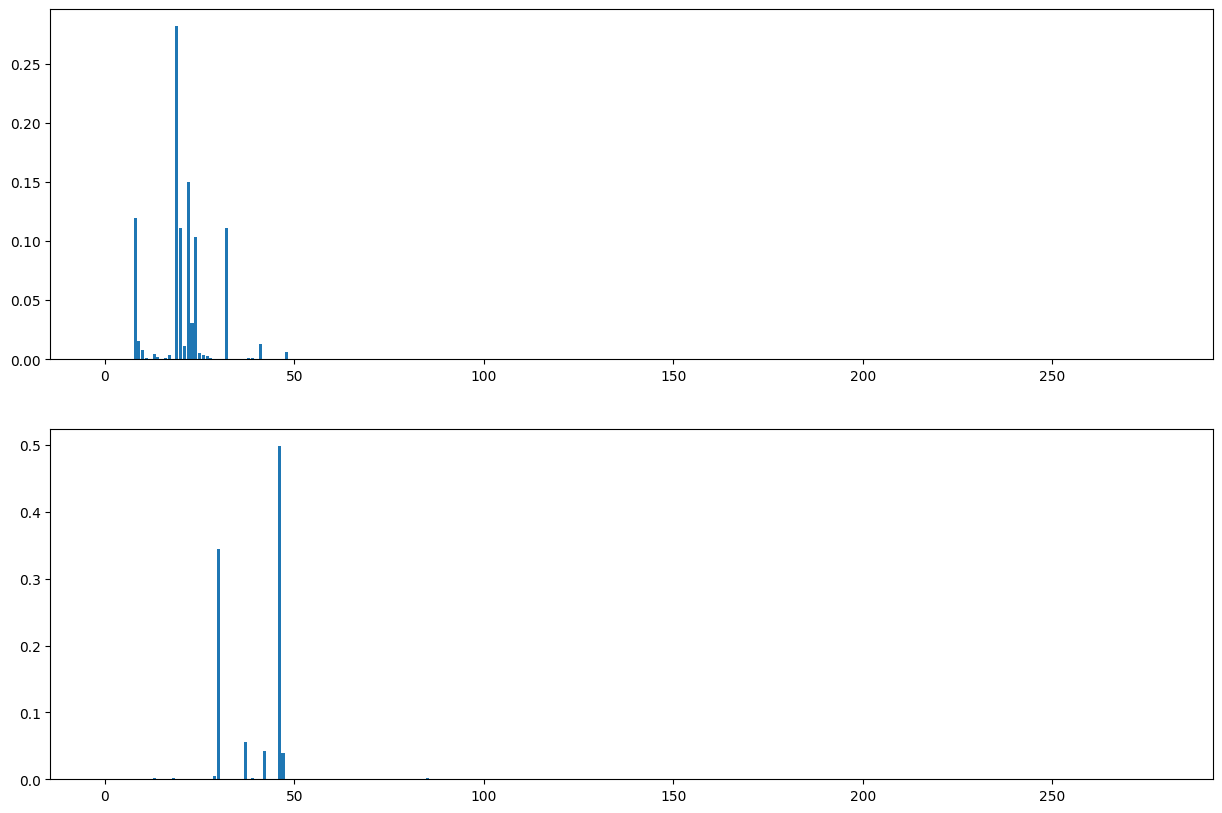

In [87]:
fig, (ax1,ax2)  = plt.subplots(2,1,figsize=(15,10))
ax1.bar(range(len(tokens)),start_probs)
ax2.bar(range(len(tokens)),end_probs)
plt.show()


In [88]:
# 결론 : 확률이 고르게 분산 -> 답을 못찾은 경우, 특정구간에 집중되면 확신있는 답을 찾음

offset mattping : 토큰단위로 찾다보면 단어가 분리되어서 자연스럽지 못하기 때문에 문자위치로 변환하는 과정을 거쳐야 자연스러운 문장이 나온다

In [89]:
'''
문맥 : Paris is the capital of France.
       012345678901234  <- 문자 인덱스
토큰 : ['Paris','is','the','capital','of','France','.']
          0       1     2     3         <-토큰인덱스
'''
# 모델은 토큰인덱스 로 작동(3번 토큰  'capital')
# 답변위치는 문자인덱스 (13번째 문자부터 'capital' 시작)
offset_mapping = [
    (0,5),   # 토큰 0: "Paris"는 문자 0 ~ 5
    (6,8),   # 토큰 1 : is 는 문자 6 ~ 8
    (9,12),
    (13,20)
]
# 활용
# 문자위치 -> 토큰위치 : Fine-tuning시 답변 레이블 생성
# 토큰위치 -> 문자위치 : 예측 결과를 원문에 매칭

In [95]:
# 토큰위치 <-> 문자위치 변환
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
question = "What is AI?"
context = "Artificial Intelligence (AI) is the simulation of human intelligence in machines."
inputs =  tokenizer(
    question,
    context,
    return_tensors = 'pt',
    return_offsets_mapping = True
)
# 토큰리스트
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
offset_mapping =  inputs['offset_mapping'][0].tolist()
# 전체 텍스트(질문 + 문맥)
full_text = question + context
# 토큰별 위치 매핑
print(f"{'인덱스':<8}{'토큰':<25}{'문자위치':<18}{'원문매칭'}")
for idx, (token, (start, end)) in enumerate(zip(tokens, offset_mapping)):
  if start == end == 0:  # 특수 토큰
      matched_text = "[특수 토큰]"
      position = "N/A"
  else:
      # 원래 텍스트에서 추출
      matched_text = full_text[start:end]
      position = f"({start:3d}, {end:3d})"

  # 답변 영역 하이라이트
  highlight = "" if "AI" in token or "Intelligence" in token else "  "
  print(f"{idx:<8} {token:<25} {position:<18} '{matched_text}' {highlight}")

인덱스     토큰                       문자위치              원문매칭
0        [CLS]                     N/A                '[특수 토큰]'   
1        What                      (  0,   4)         'What'   
2        is                        (  5,   7)         'is'   
3        AI                        (  8,  10)         'AI' 
4        ?                         ( 10,  11)         '?'   
5        [SEP]                     N/A                '[특수 토큰]'   
6        Art                       (  0,   3)         'Wha'   
7        ##ific                    (  3,   7)         't is'   
8        ##ial                     (  7,  10)         ' AI'   
9        Intelligence              ( 11,  23)         'Artificial I' 
10       (                         ( 24,  25)         't'   
11       AI                        ( 25,  27)         'el' 
12       )                         ( 27,  28)         'l'   
13       is                        ( 29,  31)         'ge'   
14       the                       ( 32,  35)         'ce '

In [103]:
# 실제 답변 위치
answer = 'Artificial Intelligence'
# 문맥에서 답변의 문자 위치 찾기
answer_start_char = context.index(answer)
answer_end_char = answer_start_char + len(answer)
# 문자위치 -> 토큰위치 변환
answer_start_token = None
answer_end_token = None
# 질문부분 건너뛰기  (sequence_id)
sequence_id = inputs.sequence_ids(0)
context_start_idx = sequence_id.index(1)  # 첫번재 문맥시작
# 문맥에서 절대 위치를 계산하기 위해 질문 길이 보정
qeustion_length = len(question) + 1 # +1 은 공백
abs_answer_start = answer_start_char + qeustion_length
abs_answer_end = answer_end_char + qeustion_length
print(f'질문 길이 보정 : +(question_length)')
print(f'절대 문자 위치: {abs_answer_start} ~ {abs_answer_end}')

질문 길이 보정 : +(question_length)
절대 문자 위치: 12 ~ 35


In [108]:
for idx in range(context_start_idx, len(offset_mapping)):
  start, end = offset_mapping[idx]
  if start == end == 0:  # 특수 토큰 무시
      continue
  # 답변 시작 토큰 찾기
  if answer_start_token is None and end > abs_answer_start:
      answer_start_token = idx
      print(f"    시작 토큰 발견!")
      print(f"     인덱스: {idx}")
      print(f"     토큰: '{tokens[idx]}'")
      print(f"     오프셋: ({start}, {end})")
      print()

  # 답변 종료 토큰 찾기
  if answer_end_token is None and start >= abs_answer_end:
      answer_end_token = idx - 1
      print(f"    종료 토큰 발견!")
      print(f"      인덱스: {idx - 1}")
      print(f"      토큰: '{tokens[idx-1]}'")
      print(f"      오프셋: {offset_mapping[idx-1]}")
      break

  print("\n" + "="*80)
  print("최종 결과")
  print("="*80)

  if answer_start_token and answer_end_token:
    print(f"\n 변환 성공!")
    print(f"   토큰 위치: {answer_start_token} ~ {answer_end_token}")
    print(f"   토큰 리스트: {tokens[answer_start_token:answer_end_token+1]}")

    # 역변환 확인
    reconstructed = tokenizer.convert_tokens_to_string(
        tokens[answer_start_token:answer_end_token+1]
    )
    print(f"   복원된 텍스트: '{reconstructed}'")
    print(f"   원본 텍스트: '{answer}'")

    if answer.lower() in reconstructed.lower():
        print(f"\n   검증 성공! 완벽하게 매칭됩니다.")
    else:
        print(f"\n   부분 일치 (토크나이제이션으로 인한 차이)")
  else:
   print("\n 변환 실패 - 답변을 찾을 수 없습니다")


    #  Offset Mapping이란?
    #    각 토큰이 원본 텍스트의 어느 위치에 해당하는지 기록

    #  형식:
    #    [(start_char, end_char), ...]
    #    - start_char: 토큰 시작 문자 위치
    #    - end_char: 토큰 종료 문자 위치 (exclusive)

    # 변환 방법:
    #    1. 문자 위치 → 토큰 위치
    #       - offset_mapping을 순회
    #       - 문자 위치가 offset 범위 내에 있는 토큰 찾기

    #    2. 토큰 위치 → 문자 위치
    #       - offset_mapping[토큰_인덱스] 직접 참조

    # 주의사항:
    #    - 특수 토큰은 (0, 0)으로 표시
    #    - truncation으로 잘린 부분은 offset 없음
    #    - Fine-tuning 시 필수적으로 사용!

    # 활용:
    #    - SQuAD 데이터 전처리: 답변 문자 위치 → 토큰 위치
    #    - 예측 결과 해석: 토큰 위치 → 원문 매칭
    #    - 답변 검증: 예측한 토큰이 실제 답변과 일치하는지 확인



최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토큰 위치: 9 ~ 14
   토큰 리스트: ['Intelligence', '(', 'AI', ')', 'is', 'the']
   복원된 텍스트: 'Intelligence ( AI ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)

최종 결과

 변환 성공!
   토

In [109]:
# SQuAD 데이터 전처리
# SQuAD 모델이 이해할 수 있는 형식으로 바꾸는 과정에 대한 이해
'''
{
  'question':'When was ......?",
  'context' : 'The Eiffel Tower......",
  'asnwer':{
    'text':["1889"],
    'asnwer_start':[31]  <- 문자위치
  }
}
'''
# 1. 토크나이제이션
# [CLS] When was ... [SEP] the eiffel tower...... [SEP]

# 2.답변 문자 위치 확인
answer_start_char = 31
answer_end_char = 35 # (31 + len('1889'))
# 3. sequence_ids로 문맥 범위 찾기
context_range = [10,45] # 토큰10번 ~ 45번이 문맥
# 4 offset_mapping 으로 토큰위치 변환
aswer_start_token = 18  # (토큰18번 = 1889의  시작)
aswer_end_token = 19 # (토큰19번 = 1889의  끝)
# 5 검증  답변이 문맥 내-->yes  , truncate로 잘리지 않음->yes
# 6 최종 학습데이터 생성
'''
      {
        'input_ids':....
        'attention_mask':....
        'start_positions':18,
        'end_positions':19
      }
'''

"\n      {\n        'input_ids':....\n        'attention_mask':....        \n        'start_positions':18,\n        'end_positions':19\n      }\n"

In [21]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# SQuAD 데이터 샘플
sample = {
    "question": "When was the Eiffel Tower built?",
    "context": "The Eiffel Tower was built in 1889 for the Paris World's Fair. It was designed by Gustave Eiffel and remains one of the most iconic structures in the world.",
    "answers": {
        "text": ["1889"],
        "answer_start": [30]  # "1889"의 문자 시작 위치
    }
}

# 토크나이제이션
inputs = tokenizer(
    sample['question'],
    sample['context'],
    max_length = 384,
    truncation = 'only_second',   # 문맥만 자르기
    return_offsets_mapping = True, # 오프셋 매핑
    return_tensors = 'pt',
    padding = 'max_length'   # 최대 길이로 패딩
)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(f'총 토큰수 : {len(tokens)}')
print(f'실제 : {inputs['attention_mask'][0].tolist().count(1)}')
print(f'패딩 : {inputs['attention_mask'][0].tolist().count(0)}')

총 토큰수 : 384
실제 : 49
패딩 : 335


In [22]:
# 답변 문자위치 확인
answer_text = sample['answers']['text'][0]
answer_start_char = sample['answers']['answer_start'][0]
answer_end_char = answer_start_char + len(answer_text)
print(f'답변 텍스트 : {answer_text}')
print(f'답변 시작 : {answer_start_char}')
print(f'답변 종료 : {answer_end_char}')
print(f"검증 : {sample['context'][answer_start_char:answer_end_char]}")

답변 텍스트 : 1889
답변 시작 : 30
답변 종료 : 34
검증 : 1889


In [ ]:
# sequence_id로 문맥 범위 찾기
# token_type_id 와 유사  문장의 종류  0:질문 , 1:문장  None:특수토큰 또는 패딩
sequence_ids = inputs.sequence_ids(0)
# 문맥의 시작과 끝
context_start = sequence_ids.index(1)
context_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1
print(f'특수토큰 : {sequence_ids.count(None)}')
print(f'0 질문 : {sequence_ids.count(0)}')
print(f'1 문맥 : {sequence_ids.count(1)}')
print(f'문맥 시작 : {context_start}')
print(f'문맥 종료 : {context_end}')
print(f'문맥 첫번째 토큰 : {tokens[context_start]}')
print(f'문맥 마지막 토큰 : {tokens[context_end]}')